In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [6]:
s = maf.HealpixSlicer(nside=512)

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [10]:
# Metric in development

class TemplateTime(maf.BaseMetric):
    """Find the time at which we expect to hit incremental template availability.
    
    Note that there are some complications to real template generation that make this an 
    approximation and not an exact answer -- one aspect is that templates are generated in 
    `patches` and not per pixel. However, it may be possible to generate parts of these patches
    at about 5arcsecond scales, which implies running with a healpix slicer at nside=512 or 1024. 
    
    Parameters
    ----------
    n_visits : `int`, opt
        Number of qualified visits required for incremental template generation. 
        Default 3. 
    seeing_range : `float`, opt
        Range of seeing to allow in the qualified images. 
    m5_range : `float`, opt
        Range of m5 values to allow in the qualified images. Stand in for `weight` in template.
    seeingCol : `str`, opt
        Name of the seeing column to use.
    m5Col : `str`, opt
        Name of the five sigma depth columns.
    nightCol : `str`, opt
        Name of the column describing the night of the visit.
    """
    
    def __init__(self, n_visits=3, seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 nightCol = 'night', **kwargs):
        self.n_visits = n_visits
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.nightCol = nightCol
        if 'metricName' in kwargs:
            self.metricName = kwargs['metricName']
            del kwargs['metricName']
        else:
            self.metricName = 'TemplateTime'
        super().__init__(col=[self.seeingCol, self.m5Col, self.nightCol], 
                         metricName=self.metricName, units="days", **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # Bail if not enough visits at all
        if len(dataSlice) < self.n_visits:
            return self.badval
        
        # Check that the visits are sorted in night
        dataSlice.sort(order=self.nightCol)
        
        # Find the best seeing in the first few images
        bench_seeing = np.min(dataSlice[self.seeingCol][0:self.n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:self.n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)

        both = np.where(seeing_ok & m5_ok)[0]
        if len(both) < self.n_visits:
            return self.badval
            
        idx_template = both[self.n_visits - 1]
        
        n_template = dataSlice[self.nightCol][idx_template]
        d_n = n_template - dataSlice[self.nightCol][0]

        return [n_template, d_n, idx_template + 1]
        
    def reduceNight(self, metricVal):
        return metricVal[0]
    
    def reduceDeltaNight(self, metricVal):
        return metricVal[1]
    
    def reduceNVis(self, metricVal):
        return metricVal[2]

In [11]:
opsdb = get_baseline()
runName = os.path.split(opsdb)[-1].replace('.db', '')

In [12]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metricName=f'Template {f}')
    constraint = f'filter == "{f}"'
    bdict[f] = maf.MetricBundle(m, s, constraint, runName=runName)
    
g = maf.MetricBundleGroup(bdict, opsdb, 'temp')
g.runAll()

Querying table None with constraint filter == "g" for columns ['fieldRA', 'rotSkyPos', 'seeingFwhmEff', 'fiveSigmaDepth', 'night', 'fieldDec']
Found 214824 visits
Running:  ['g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "y" for columns ['fieldRA', 'rotSkyPos', 'seeingFwhmEff', 'fiveSigmaDepth', 'night', 'fieldDec']
Found 390128 visits
Running:  ['y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "z" for columns ['fieldRA', 'rotSkyPos', 'seeingFwhmEff', 'fiveSigmaDepth', 'night', 'fieldDec']
Found 402511 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "i" for columns ['fieldRA', 'rotSkyPos', 'seeingFwhmEff', 'fiveSigmaDepth', 'night', 'fieldDec']
Found 473232 visits
Running:  ['i']
Complete

In [14]:
bdict.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'y', 'Template g_DeltaNight', 'Template g_NVis', 'Template g_Night', 'Template y_DeltaNight', 'Template y_NVis', 'Template y_Night', 'Template z_DeltaNight', 'Template z_NVis', 'Template z_Night', 'Template i_DeltaNight', 'Template i_NVis', 'Template i_Night', 'Template r_DeltaNight', 'Template r_NVis', 'Template r_Night', 'Template u_DeltaNight', 'Template u_NVis', 'Template u_Night'])

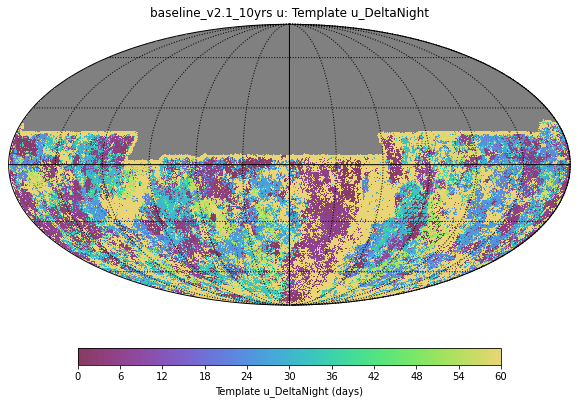

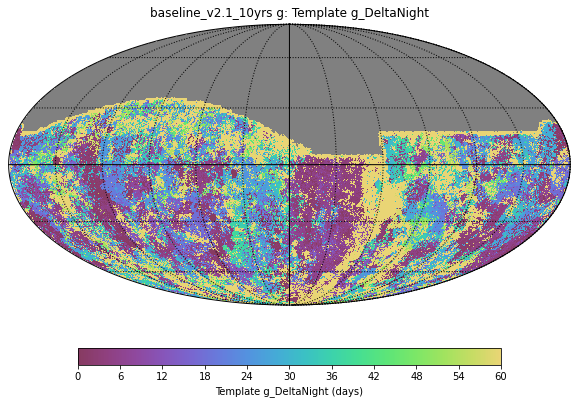

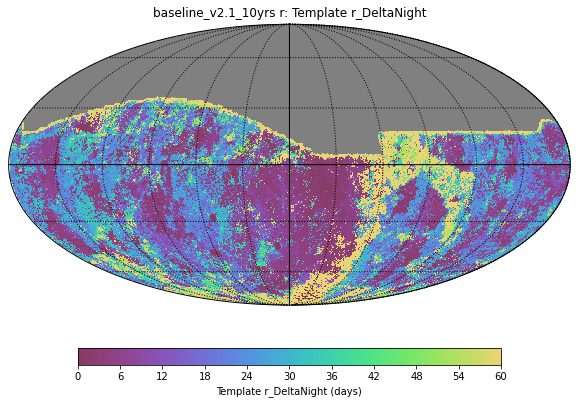

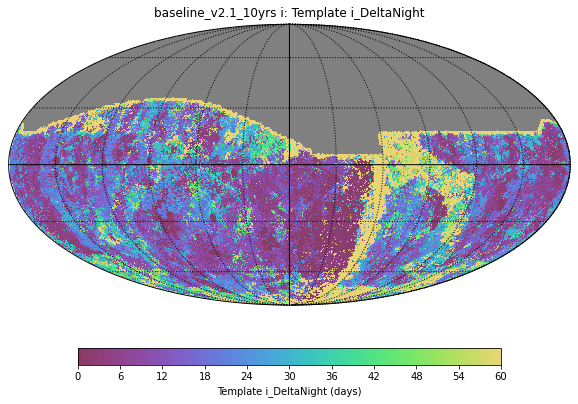

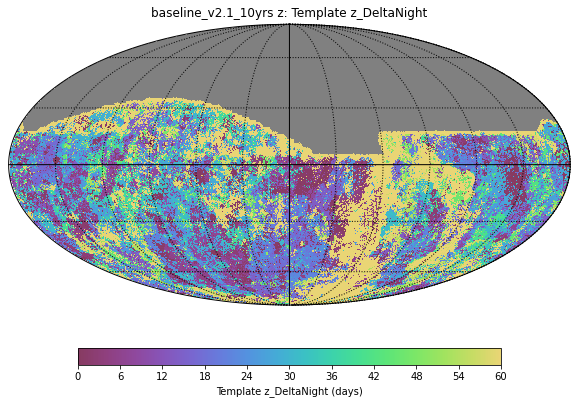

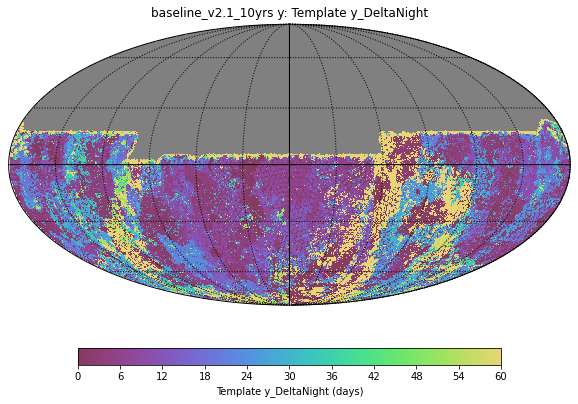

In [16]:
ph = maf.PlotHandler(outDir='temp', thumbnail=False)

for f in 'ugrizy':
    k = f'Template {f}_DeltaNight'
    ph.setMetricBundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'colorMin': 0, 'colorMax': 60}
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plotDict)

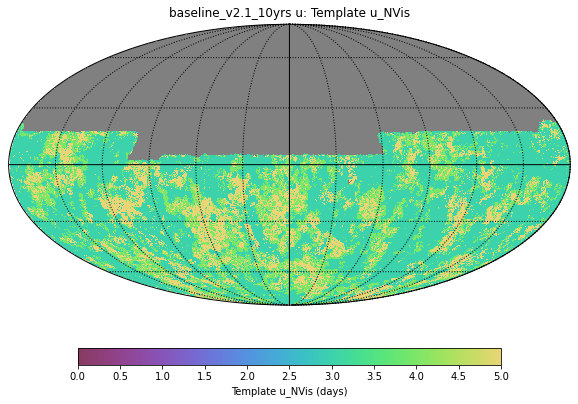

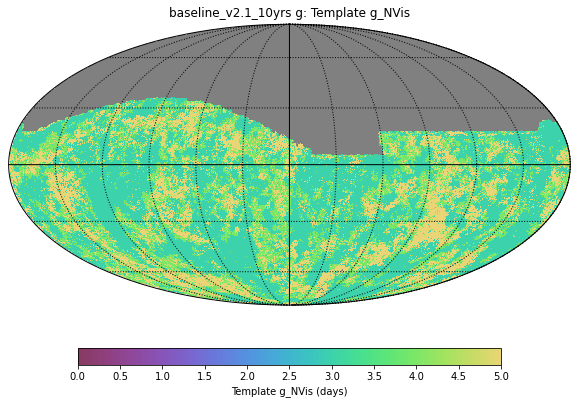

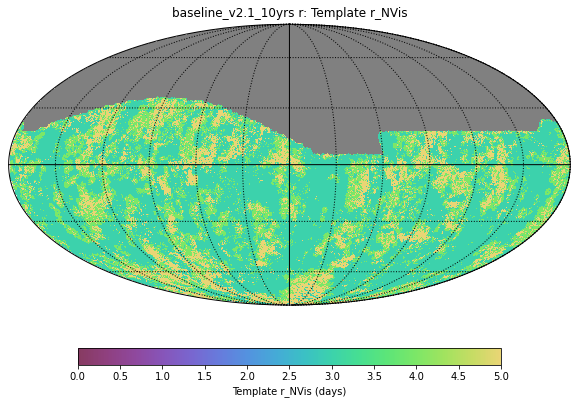

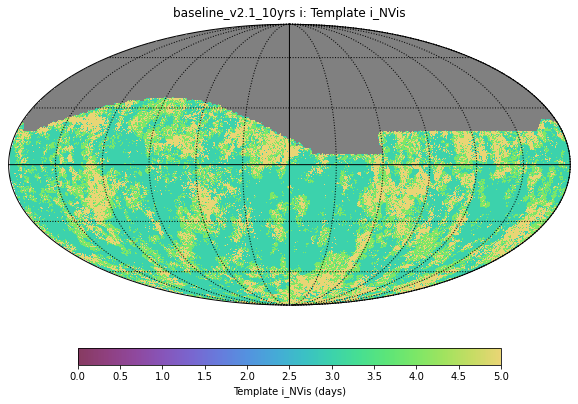

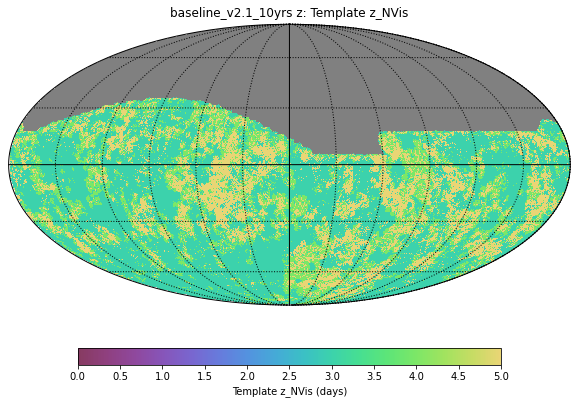

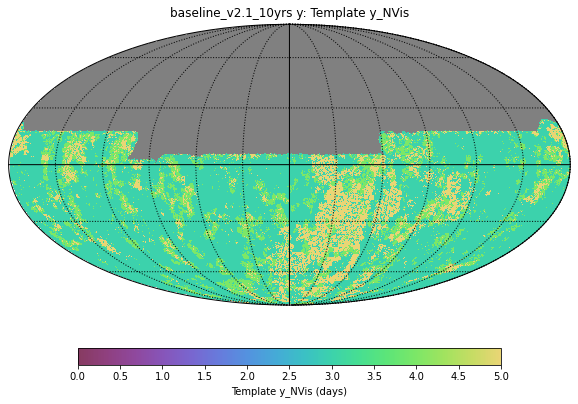

In [18]:
for f in 'ugrizy':
    k = f'Template {f}_NVis'
    ph.setMetricBundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'colorMin': 0, 'colorMax': 5}
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plotDict)

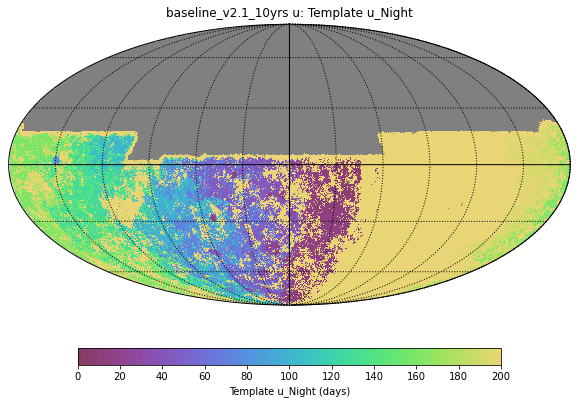

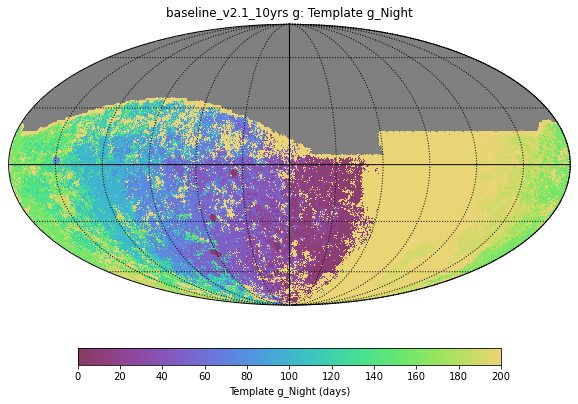

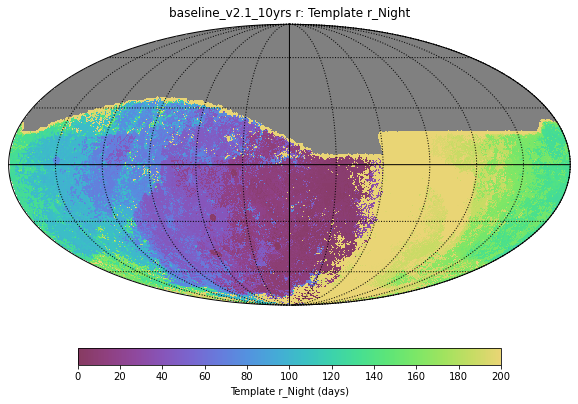

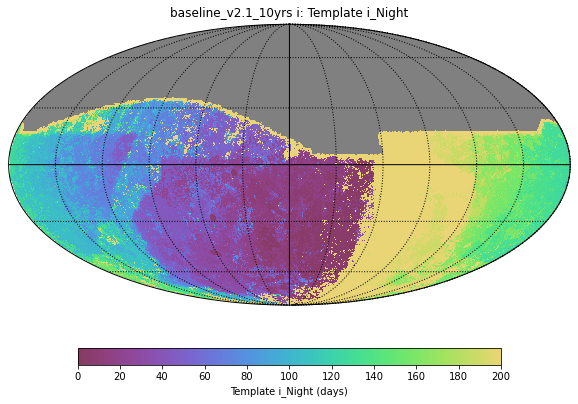

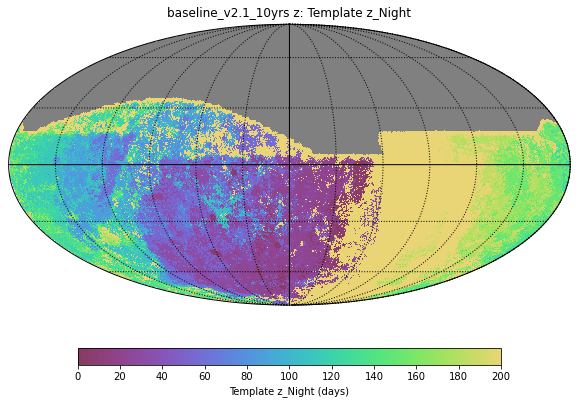

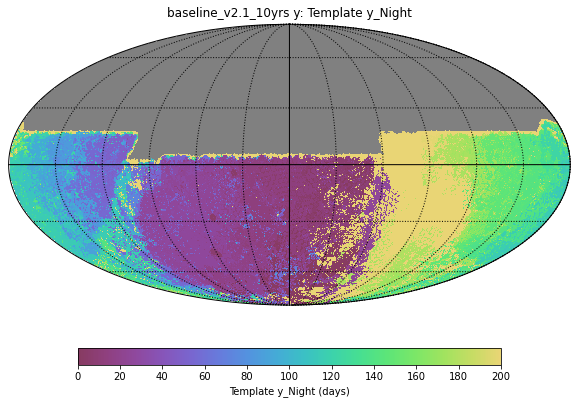

In [20]:
for f in 'ugrizy':
    k = f'Template {f}_Night'
    ph.setMetricBundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'colorMin': 0, 'colorMax': 200}
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plotDict)